# 3.6 Reconciling projections

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.6-Reconciling-projections" data-toc-modified-id="3.6-Reconciling-projections-1">3.6 Reconciling projections</a></span><ul class="toc-item"><li><span><a href="#3.6.1-Introduction" data-toc-modified-id="3.6.1-Introduction-1.1">3.6.1 Introduction</a></span></li><li><span><a href="#3.6.2-Requirements" data-toc-modified-id="3.6.2-Requirements-1.2">3.6.2 Requirements</a></span><ul class="toc-item"><li><span><a href="#3.6.2.1-Get-the-MODIS-LAI-dataset-for-2016/2017-for-W.-Europe" data-toc-modified-id="3.6.2.1-Get-the-MODIS-LAI-dataset-for-2016/2017-for-W.-Europe-1.2.1">3.6.2.1 Get the MODIS LAI dataset for 2016/2017 for W. Europe</a></span></li><li><span><a href="#3.6.2.2-Read-the-LAI-dataset-for-a-given-country-and-year" data-toc-modified-id="3.6.2.2-Read-the-LAI-dataset-for-a-given-country-and-year-1.2.2">3.6.2.2 Read the LAI dataset for a given country and year</a></span></li><li><span><a href="#3.6.2.3-register-with-ECMWF-and-install-the-API" data-toc-modified-id="3.6.2.3-register-with-ECMWF-and-install-the-API-1.2.3">3.6.2.3 register with ECMWF and install the API</a></span></li><li><span><a href="#3.6.2.4-Get-the-2t-dataset-from-ECMWF-for-Europe" data-toc-modified-id="3.6.2.4-Get-the-2t-dataset-from-ECMWF-for-Europe-1.2.4">3.6.2.4 Get the 2t dataset from ECMWF for Europe</a></span></li><li><span><a href="#3.6.2.5-Get-the-shapefile-for-country-borders" data-toc-modified-id="3.6.2.5-Get-the-shapefile-for-country-borders-1.2.5">3.6.2.5 Get the shapefile for country borders</a></span></li></ul></li><li><span><a href="#3.6.3-Reconcile-the-datasets" data-toc-modified-id="3.6.3-Reconcile-the-datasets-1.3">3.6.3 Reconcile the datasets</a></span><ul class="toc-item"><li><span><a href="#3.6.3.1-load-an-exemplar-dataset" data-toc-modified-id="3.6.3.1-load-an-exemplar-dataset-1.3.1">3.6.3.1 load an exemplar dataset</a></span></li></ul></li></ul></li><li><span><a href="#Model-calibration" data-toc-modified-id="Model-calibration-2">Model calibration</a></span><ul class="toc-item"><li><span><a href="#Defining-and-implementing-a-cost-function" data-toc-modified-id="Defining-and-implementing-a-cost-function-2.1">Defining and implementing a cost function</a></span></li><li><span><a href="#Solving-for-optimal-estimate" data-toc-modified-id="Solving-for-optimal-estimate-2.2">Solving for optimal estimate</a></span></li><li><span><a href="#Look-up-table" data-toc-modified-id="Look-up-table-2.3">Look up table</a></span><ul class="toc-item"><li><span><a href="#A-faster-LUT" data-toc-modified-id="A-faster-LUT-2.3.1">A faster LUT</a></span></li></ul></li><li><span><a href="#Exercise" data-toc-modified-id="Exercise-2.4">Exercise</a></span></li><li><span><a href="#Using-a-minimisation-routine" data-toc-modified-id="Using-a-minimisation-routine-2.5">Using a minimisation routine</a></span></li><li><span><a href="#Exercise" data-toc-modified-id="Exercise-2.6">Exercise</a></span></li></ul></li></ul></div>

## 3.6.1 Introduction

This section of notes is optional to the course, and the tutor may decide *not* to go through this in class. That said, the information and obexamples contained here can be very useful for accessing and processing certain types of geospatial data.

In particular, we deal with obtaining climate data records from [ECMWF](http://apps.ecmwf.int/datasets/data/era40-daily/levtype=sfc) that we will later use for model fitting. These data come in a [netcdf](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) format (commonly used for climate data) with a grid in latitude/longitude. To 'overlay' these data with another dataset (e.g. the MODIS LAI product that we have been using) in a different (equal area) projection, we use the `gdal` function

    gdal.ReprojectImage(src, dst, src_proj, dst_proj, interp)
       
where:

    src      : a source dataset that we want to process 
    dst      : a blank destination dataset that we set up with the 
               required (output) data type, shape, and geotransform and projection
    src_proj : the source dataset projection wkt 
    dst_proj : the destination projection wkt 
    interp   : the required interpolation method, e.g. gdalconst.GRA_Bilinear
    
where wkt stands for [well known text](https://en.wikipedia.org/wiki/Well-known_text) and is a projection format string.

Other codes we use are ones we have developed earlier.

In these notes, we will learn:

    * how to access an ECMWF daily climate dataset (from ERA interim)
    * how to reproject the dataset to match another spatial dataset (MODIS LAI)
    
We will then save some datasets that we will use later in the notes. For this reason, it's possile to skip this section, and return to it later.

## 3.6.2 Requirements

We will need to:

* make sure we have the MODIS LAI dataset locally
* read them in for a given country.
* register with ecmwf, install ecmwfapi
* get the temperature datasset from ECMWF for 2006 and 2017 for Europe
* get the country borders shapefile

In [12]:
# required general imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
from pathlib import Path
import gdal
from datetime import datetime, timedelta

### 3.6.2.1 Get the MODIS LAI dataset for 2016/2017 for W. Europe

You will probably already have this dataset, but running the code below will make sure that you do.

In [35]:
# get the MODIS LAI dataset for 2016/2017 for W. Europe
from geog0111.geog_data import procure_dataset
from pathlib import Path

files = list(Path('data').glob('MCD15A3H.A201[6-7]*h1[7-8]v0[3-4].006*hdf'))
if len(files) < 732:
    _ = procure_dataset("lai_files",verbose=False)

### 3.6.2.2 Read the LAI dataset for a given country and year

Run the code below to read in the LAI dataset for a given year and country. This uses codes we have developed in previous sections, interfaced through `process_timeseries()`.

In the code, we can save the dataset as an `npz` file, so that we can access it faster next time. If you don't want to use disk space to do that however, simply set `save = False` below.

In [33]:
# read in the LAI data for given country code
from geog0111.process_timeseries import process_timeseries
'''
Note, the saved npz file can be quite large
e.g. 8.1 G for France.

You can override saving it by setting save = False
but if it is saved, it will be faster to access
data the next time you need it.
'''
country_code = 'FR'
year = 2017
save = True

tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        
ofile = Path('data')/f'lai_data_{year}_{country_code}.npz'

if not ofile.exists():
    dates, lai_array, weights_array = process_timeseries(year,tiles,\
                                                     country_code=country_code)
    lai = {'dates':dates, 'lai':lai_array, 'weights':weights_array}
    if save:
        np.savez(ofile,**lai)
else:
    # read it from npz file
    lai = np.load(ofile)

### 3.6.2.3 register with ECMWF and install the API

First, you should [register as a user with ECMWF](https://apps.ecmwf.int/auth/login).

The first time:

* register and follow the emailed instructions.

* read and acknowledge the [conditions of access and related information](https://www.ecmwf.int/en/computing/access-computing-facilities/conditions-access-ecmwf-computing-services).

* follow the instructions on [how to access datasets](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets) to set up receive and set up [an ECMWF key](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets#AccessECMWFPublicDatasets-key)

Help is available [online](https://confluence.ecmwf.int/display/UDOC/User+Documentation).

In [36]:
# install ecmwf api -- do this once only
try:
    from ecmwfapi import ECMWFDataServer
except:
    !cd data/ecmwf; python setup.py install --user

### 3.6.2.4 Get the 2t dataset from ECMWF for Europe

Run the code below to request and download the daily 2m temperature dataset for 2016 and 2017 (0.25 degree resolution) from the ECMWF ERA interim data.

If the file already exists locally, the request will be ignored.

If you do need to run the request, it may take several hours, depending on the ECMWF queue at the time.

In [41]:
from ecmwfapi import ECMWFDataServer
from pathlib import Path
from geog0111.geog_data import procure_dataset

ofile = 'europe_data_2016_2017.nc'
if not (Path('data')/ofile).exists():
    # try to get it from UCL servers
    try:
        _ = procure_dataset(ofile,verbose=True)
    except:
        server = ECMWFDataServer()
        print('requesting data ... may take some time')
        server.retrieve({
            "class": "ei",
            "dataset": "interim",
            "date": "2016-01-01/to/2017-12-31", # Time period
            "expver": "1",
            "levtype": "sfc",
            "param": "2t",           # Parameters. Here we use 2m Temperature (2t)  See the ECMWF parameter database, at http://apps.ecmwf.int/codes/grib/param-db
            "stream": "oper",
            "type": "an",
            "time": "12",
            "step": "0",
            "area": "75/-20/10/60",    # Subset or clip to an area, here to Europe. Specify as North/West/South/East in Geographic lat/long degrees. Southern latitudes and Western longitudes must be given as negative numbers.
            "grid": "0.25/0.25",        # Regrid from the default grid to a regular lat/lon with specified resolution. The first number is east-west resolution (longitude) and the second is north-south (latitude).
            "format": "netcdf",         # Convert the output file from the default GRIB format to NetCDF format. Requires "grid" to be set to a regular lat/lon grid.
            "target": f"data/{ofile}",  # The output file name. Set this to whatever you like.
        })
else: print(f'{ofile} exists')

europe_data_2016_2017.nc exists
europe_data_2016_2017.nc exists


### 3.6.2.5 Get the shapefile for country borders

Again, you should already have this, but just to make sure:

In [42]:
import requests
import shutil
from pathlib import Path

force = False
# zip file
zipfile = 'TM_WORLD_BORDERS-0.3.zip'
# URL
tm_borders_url = f"http://thematicmapping.org/downloads/{zipfile}"
# destibnation folder
destination_folder = Path('data')

# set up some filenames
zip_file = destination_folder.joinpath(zipfile)
shape_file = zip_file.with_name(zipfile.replace('zip', 'shp'))

# download zip if need to
if not Path(zip_file).exists():
    r = requests.get(tm_borders_url)
    with open(zip_file, 'wb') as fp:
        fp.write(r.content)

# extract shp from zip if need to
if force or not Path(shape_file).exists():
    shutil.unpack_archive(zip_file.as_posix(), extract_dir=destination_folder)
    

## 3.6.3 Reconcile the datasets

### 3.6.3.1 load an exemplar dataset

Since we want to match up datasets, we need to produce an example of the dataset we want to match up to.

We save the exemplar as a GeoTiff format file here.

data/Lai_500m_2017_001_FR.tif
data/Lai_500m_2017_001_FR.tif


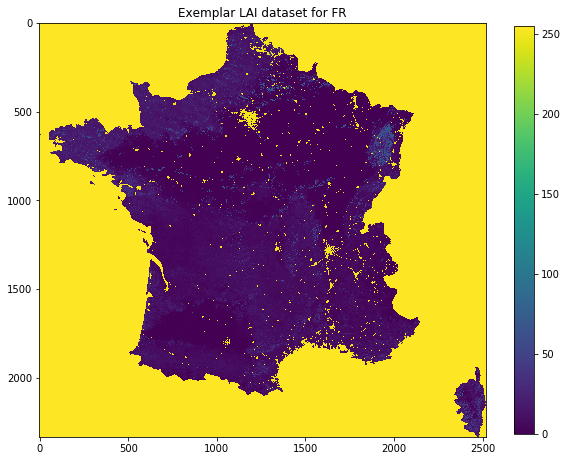

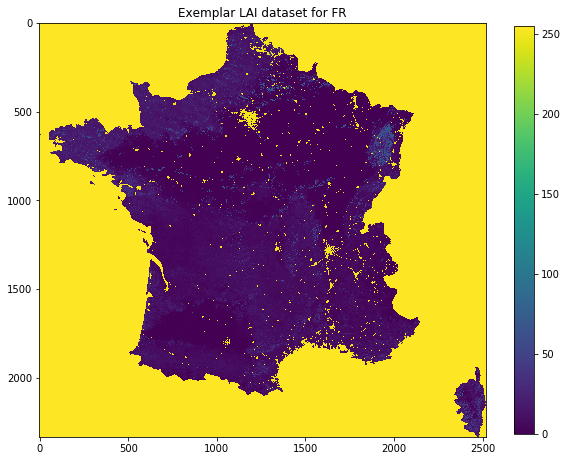

In [54]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip


country_code = 'FR'
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"

'''
https://stackoverflow.com/questions/10454316/
how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
'''
        
# first get an exemplar LAI file, clipped to
# the required limits. We will use this to match  
# the t2 dataset to
match_filename = mosaic_and_clip(tiles,1,2017,\
                    country_code=country_code,shpfile=shpfile,frmat='GTiff')

print(match_filename)

'''
Now get the projection, geotransform and dataset
size that we want to match to
'''
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

plt.figure(figsize=(10,10))
plt.title(f'Exemplar LAI dataset for {country_code}')
plt.imshow(match_ds.ReadAsArray())
plt.colorbar(shrink=0.75)
# close the file -- we dont need it any more
del match_ds

Now, we pull the information we need from the source file (the netcdf format t2 dataset).

We need to know:

* the data type
* the number of bands (time samples in this case)
* the geotransform of the dataset (the fact that it's 0.25 degree resolution over Europe)

and access these from the source dataset.



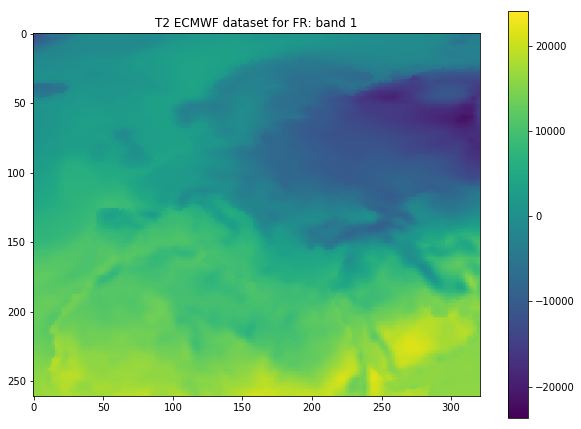

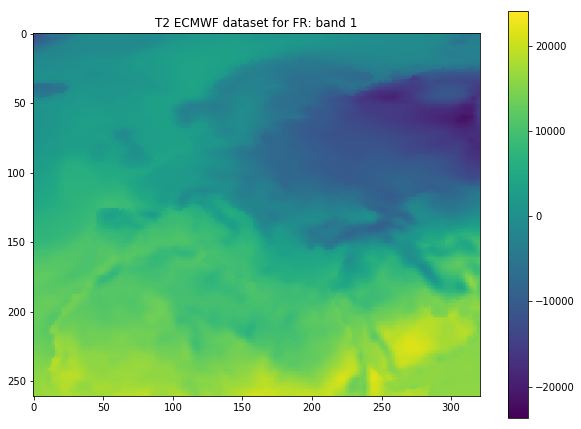

In [67]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip

# set up conditions

src_filename = 'data/europe_data_2016_2017.nc'

'''
access information from source
'''
src_dataname = 'NETCDF:"'+src_filename+'":t2m'
src = gdal.Open(src_dataname, gdalconst.GA_ReadOnly)
'''
Get geotrans, data type and number of bands
from source dataset
'''
band1 = src.GetRasterBand(1)

src_geotrans = src.GetGeoTransform()
nbands = src.RasterCount
src_format = band1.DataType

# visualise
plt.figure(figsize=(10,10))
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(band1.ReadAsArray())
plt.colorbar(shrink=0.75)

The netcdf dataset is in a lat/long projection. Usually, we can access this information from:

    src.GetProjection()
    
but this returns a zero-length string from the netcdf file because of the way the corrdinate system data are set.

So, we have to provide information to `gdal.ReprojectImage()` about the projection. The geoid used by the data is [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System). Information on [`spatialreference.org`](http://spatialreference.org/ref/epsg/wgs-84/) tells us that the appropriate [EPSG](http://spatialreference.org/ref/epsg/) is [4326](http://spatialreference.org/ref/epsg/wgs-84/):

In [69]:
from osgeo import gdal, gdalconst,osr

# try to get the src projection 
src_proj = src.GetProjection ()

# if (when) we fail, tell it its wgs84
if len(src_proj) == 0:
    # set up a spatial reference
    # as wgs84 
    wgs84 = osr.SpatialReference ()
    wgs84.ImportFromEPSG ( 4326 )
    src_proj = wgs84.ExportToWkt()

Now, set up a blank gdal dataset (in memory) with the size, data type, projection etc. that we want, the reproject the temperature dataset into this.

The processing may take som e time if the LAI dataset is large (e.g. France).

The result will be of the same size, projection etc as the cropped LAI dataset.



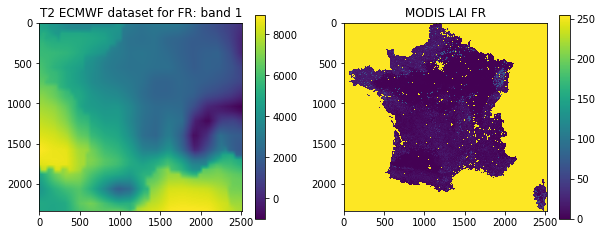

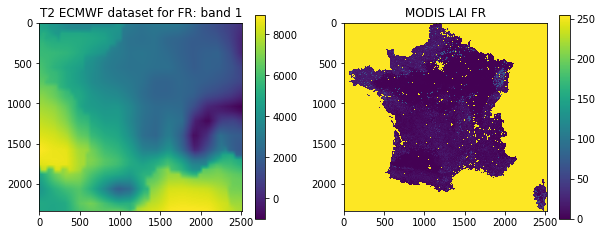

In [79]:
dst = gdal.GetDriverByName('MEM').Create('', wide, high, nbands, src_format)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work: reproject the dataset
_ = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

'''
Visualise
'''
t2 = dst.GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(10,5))
plt.subplot ( 1, 2, 1 )
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(t2)
plt.colorbar(shrink=0.75)
plt.subplot ( 1, 2, 2 )
plt.title(f'MODIS LAI {country_code}')
plt.imshow(match_ds)
plt.colorbar(shrink=0.75)

Finally, we crop the temperature dataset using `gdal.Warp()` and save it to a (GeoTiff) file:

In [ ]:
 # Output / destination
dst_filename = src_filename.replace('.nc','.tif')
# get the no data value: -32767 here
frmat = 'GTiff'
gdal.Warp(dst_filename,
            dst,
            format=frmat,
            dstNodata=-32767,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
del dst # Flush

In [ ]:
# visualise
t2 = gdal.Open(dst_filename, gdalconst.GA_ReadOnly).GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(10,5))
plt.subplot ( 1, 2, 1 )
plt.title(f'T2 ECMWF dataset for {country_code}: band 1')
plt.imshow(t2)
plt.colorbar(shrink=0.75)
plt.subplot ( 1, 2, 2 )
plt.title(f'MODIS LAI {country_code}')
plt.imshow(match_ds)
plt.colorbar(shrink=0.75)

In [ ]:
print(t2.shape)
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(t2[100])

# Model calibration

As an addition  to the notes on function fitting, we consider the ideas of function fitting and model calibration in a bit more detail.

We start with the example of a 'phenology' model as in the previous exercise:


![](http://www2.geog.ucl.ac.uk/~plewis/geogg124/_images/zhang1.png)

We consider a signal (e.g. NDVI) observational data.





In [ ]:
'''
    which tile and year?
'''
tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")

year = 2017

dates, lai_array, weights_array = process_timeseries(
    year,
    tiles,
    folder="data/",
    shpfile="data/TM_WORLD_BORDERS-0.3.shp",
    country_code="NL")

In [ ]:
import glob
year = 2005
tile = "h17v03"
# test it
# Search for all the files using wildcards
filelist = glob.glob ("data/MCD15A2.A{}*{}*.hdf".format(year, tile))
filelist.sort()
lai = read_lai(filelist,country='Ireland')
data = np.array(lai['Lai_1km'])
sd = np.array(lai['LaiStdDev_1km'])

# fix uncertainties
thresh = 0.25
sd[sd<thresh] = thresh

and consider a logistic function that we would like to use as a model of LAI development (phenology).

A (double) logistic function is:

$$
 \hat{y} = p_0 - p_1 \left( \frac{1}{1 + e^{p_2 (t - p_3)}} + \frac{1}{1 + e^{p_4 (t - p_5)}} -1\right)
$$

In [ ]:
def dbl_logistic_model ( p, t ):
        """
            A double logistic model, as in Sobrino and Juliean, 
            or Zhang et al
            
            Parameters:, and rough guess
              
            p[0]=  ymean - 1.151*ysd  # minimum  (1.151 is 75% CI)
            p[1] = 2*1.151*ysd        # range
            p[2] = 0.19               # related to up slope
            p[3] = 120                # midpoint of up slope
            p[4] = 0.13               # related to down slope
            p[5] = 220                # midpoint of down slope
        """
        return p[0] - p[1]* ( 1./(1+np.exp(p[2]*(t-p[3]))) + \
                              1./(1+np.exp(-p[4]*(t-p[5])))  - 1 )

In [ ]:
# test pixel
r = 442
c = 84

'''
    set up x and y data for a pixel
'''

y = data[:,r,c]
mask = np.logical_not(np.isnan(y))
y = np.array(y[mask])
x = (np.arange(46)*8+1.)[mask]
unc = np.array(sd[:,r,c][mask])
x_full = np.arange(1,366) 

# some stats on y for rough guesses
ysd = np.std(y)
ymean = np.mean(y)

# some rough guesses at the parameters
p = np.array([ymean - 1.151*ysd,2*1.151*ysd,0.1,120,0.1,240])

'''

Run the logistic model with these parameters

'''
y_hat = dbl_logistic_model(p,x_full)

plt.clf()
plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

We can now calculate the residuals. We weight the residuals by the uncertainty, to normalise and express them in 'standard deviation' units.

In [ ]:
def mismatch_function(p, x, y, unc):
    '''
    
    return the residuals 
    weighted by uncertainty
    
    '''
    y_hat = dbl_logistic_model(p, x)
    diff = (y_hat - y)/unc
    return diff

Z = mismatch_function(p,x,y,unc)

plt.plot([1,365.],[0,0.],'k-')
plt.xlim(0,365)
plt.plot(x,Z,'*')

print 'mean Z^2 =',(Z**2).mean()

## Defining and implementing a cost function

More formally, consider the observations (i.e. LAI) as Gaussian distributions $y_{obs}(x)$ ~ $N(\bar{y}(x),C_{obs}(x))$ where $,C_{obs}(x)$ is the variance/covariance matrix (uncertainty) in the LAI observations at time $x$ and $\bar{y}$ its mean.

We assume zero covariance between the errors at each observation, so $C_{obs}(x)$ is a diagonal matrix:

$
C_{obs} = 
\left( \begin{array}{ccc}
\sigma^2_0 & 0 & ... & 0 \\
0 & \sigma^2_1 & ... & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & ... & \sigma^2_{n-1} \end{array} \right) 
$

over $n$ samples (in $x$) and $\sigma^2_i$ is the variance of the $i^{th}$ sample (i.e. at $x_i$).

We note that calculating the inverse of this matrix is trivial:

$
C_{obs}^{-1} = 
\left( \begin{array}{ccc}
\frac{1}{\sigma^2_0} & 0 & ... & 0 \\
0 & \frac{1}{\sigma^2_1} & ... & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & ... & \frac{1}{\sigma^2_{n-1}} \end{array} \right) 
$


Suppose now that we have a *model*:

$
\hat{y} = f(x,p)
$

where $p$ is a set of parameters of the function.

We wish to obtain an *optimal* estimate of $p$, conditioned on the observations. 

We can do this by considering a *cost function*, $J_{obs}(y_{obs},p)$:

$
J_{obs}(y_{obs},p) = \frac{1}{2} \left[ y(x) - \hat{y}(x,p) \right]^T C_{obs}^{-1}  \left[ y(x) - \hat{y}(x,p) \right]
$

where $^T$ denotes the transpose operation. 

We could implement a general cost function of this sort as:

In [ ]:
def J_obs(p, x, y, C1,
                      model=dbl_logistic_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    C1   : inverse variance /covariance matrix
        
    '''
    y_hat = model(p, x)
    
    diff = np.matrix(y_hat - y).T
    
    return 0.5 * np.array(diff.T * C1 * diff).flatten()[0]


# calculate the inverse var/covar matrix
# NB use np matrix here
# .I gives the inverse

C1 = np.matrix(np.diag(unc**2)).I

Z = J_obs(p,x,y,C1)

print Z

But since we only want to consider a diagonal uncertainty matrix here, it is simpler and faster to use:

In [ ]:
def J_obs_fast(p, x, y, sd,\
                      model=dbl_logistic_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    sd   : uncertainty standard deviation
        
    '''
    y_hat = model(p, x)
    
    diff = (y_hat - y)/sd
    
    return 0.5 * (diff*diff).sum()


Z = J_obs_fast(p,x,y,unc)

print Z

Or ... we could design a function that could do either:

In [ ]:
def J_obs(p, x, y, sd,\
                      model=dbl_logistic_model):
    '''
    
    return 'cost' J
    
    p    : set (vector) of parameters
    x    : sample locations
    y    : function value at sample locations
    sd   : uncertainty standard deviation
           *or* if not same shape as y, then
           assumed to be C1 (inverse var/covar matrix)
        
    '''
    y_hat = model(p, x)

    if sd.shape == y.shape:
        diff = (y_hat - y)/sd
        J = 0.5 * (diff*diff).sum()
    else:
        diff = np.matrix(y_hat - y).T
        J = 0.5 * np.array(diff.T * C1 * diff).flatten()[0]
    
    return J

C1 = np.matrix(np.diag(unc**2)).I

print J_obs(p,x,y,unc)
print J_obs(p,x,y,C1)


Notice that in this example, we can change the model used for calculating $\hat{y}$ (providing we use the same *interface*):

In [ ]:
# cost using logistic model
print J_obs(p,x,y,unc,model=dbl_logistic_model)

# define another model

def sincos(p,x):
    '''
    
    y_hat = p[0] + p[1] sin(t) + p[2] cos(t)
   
    '''
    # put x in range 0 to 2 pi and call it t
    t = np.pi * 2 * x/365.25
    return p[0]*np.sin(t) + p[1] * np.cos(t)

# calculate the cost for this
p2 = [0.1,0.2,0.2]
print J_obs(p2,x,y,unc,model=sincos)


Note that the 2 models we have chosen here have rather different meanings for the parameters. Indeed, the logistic takes 6 parameters (in `p`) but the `sincos` function, only 3. 

## Solving for optimal estimate

Now, consider how Z varies as we vary `p`:

In [ ]:
# vary the first parameter

pvals = np.mgrid[0.0:1.01:0.01]
mse   = np.zeros_like(pvals)
p_ = p.copy()
print p

for i,p0 in enumerate(pvals):
    p_[0] = p0
    Z = J_obs(p_,x,y,unc,model=dbl_logistic_model)
    mse[i] = (Z**2).mean()
    

In [ ]:
plt.plot(pvals,np.sqrt(mse))
plt.xlabel('p0')
plt.ylabel('rmse')

We can consider this a 'slice' through an 'error surface' or 'cost function'. 

We can define the 'optimal' estimate of the parameter vector `p` as the set of `p` values that gives a *minimum* in the error surface, i.e. one for which:

$
\frac{\partial{J}}{\partial{p}} = 0
$

i.e. the rate of change of the error function is zero (in all dimensions).

The function $J$ in this case is 6 dimensional. It is quite hard to visualise that, but we can easily examine two dimensions.



In [ ]:
# vary the first 2 parameters

pvals = np.mgrid[0.0:2.01:0.01,0.0:3.51:0.01]
mse   = np.zeros_like(pvals[0])
p_ = p.copy()

for i in xrange(pvals.shape[1]):
    for j in xrange(pvals.shape[2]):
        for k in xrange(pvals.shape[0]):
            p_[k] = pvals[k,i,j]
            Z = J_obs(p_,x,y,unc,model=dbl_logistic_model)
            mse[i,j] = (Z**2).mean()
    

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow ( np.sqrt(mse), interpolation='nearest', extent=(0, 3.5, 0, 2.), origin="lower",
           cmap=plt.cm.BuPu_r)
plt.colorbar(orientation="horizontal", shrink=0.7)
cs = plt.contour( pvals[1], pvals[0], np.sqrt(mse), [50, 100, 150, 200, 400, 600])
plt.clabel(cs, fmt = '%2.1f', fontsize=8)

In both the one and two dimensional 'slices' we can quite easily spot the minimum of the error function. Remember that this is *only* for a particular set of values of the parameters that we do not vary here.

## Look up table

One approach to finding the global minimum would be to simply calculate $J$ at some set of points (e.g. on a six dimensional grid), and to see which point showed the minimum of $J$. We can do this here:

In [ ]:
'''
 recall the meaning of the parameters for the model we are using

 p[0]=  ymean - 1.151*ysd  # minimum  (1.151 is 75% CI) of LAI
 p[1] = 2*1.151*ysd        # range of LAI
 p[2] = 0.19               # related to up slope
 p[3] = 120                # midpoint of up slope
 p[4] = 0.13               # related to down slope
 p[5] = 220                # midpoint of down slope

'''

# consider parameter bounds

b = np.array([(0.01,10.),(0.01,10.),(0.01,1.),\
                  (50.,300.),(0.01,1.),(50.,300.)])

# number of samples per dimension (+1)
N = 5

# work out what steps to use over the grid
s = [(bound[1]-bound[0])/float(N) for bound in b]
# form a grid of samples over parameter space

pvals = np.mgrid[b[0,0]:b[0,1]+s[0]:s[0],\
                 b[1,0]:b[1,1]+s[1]:s[1],\
                 b[2,0]:b[2,1]+s[2]:s[2],\
                 b[3,0]:b[3,1]+s[3]:s[3],\
                 b[4,0]:b[4,1]+s[4]:s[4],\
                 b[5,0]:b[5,1]+s[5]:s[5]]

# set sse default to high
sse   = np.zeros_like(pvals[0]) + 1e20
p_ = p.copy()

print 'the grid shape is',pvals.shape
print 'the LUT grid has',pvals.size,'entries'

for i0 in xrange(pvals.shape[1]):
  for i1 in xrange(pvals.shape[2]):
    for i2 in xrange(pvals.shape[3]):
      for i3 in xrange(pvals.shape[4]):
        for i4 in xrange(pvals.shape[5]):
          for i5 in xrange(pvals.shape[6]):

            for k in xrange(pvals.shape[0]):
              p_[k] = pvals[k,i0,i1,i2,i3,i4,i5]
              
              try:
                Z = J_obs(p_,x,y,unc,model=dbl_logistic_model)
                sse[i0,i1,i2,i3,i4,i5] = (Z**2).sum()
              except:
                pass

but this takes a relatively long time, *even* if we use a really coarse grid as in this example (with a few hundred thousand samples).

That said, LUT inversion is a pragmatic response to trying to find an optimal solution for the parameters when fitting a model. It is viable in low dimensional space, but becomes problematic as the number of dimensions increases. 

Note also that, as it stands, it can only provide a rough estimate of the parameters:

In [ ]:
'''

Seek the minimum SSE

'''
# find the minimum value over the grid
minSSE = np.min(sse)
print 'the minimum value is',minSSE

# find where that occurs
w = np.where(sse == minSSE )
print '\nthe min is at sample',w

# a bit awkward to pull this out but it is possible
result = np.array(pvals[:,w[0],w[1],w[2],w[3],w[4],w[5]]).T[0]

print '\nthe result is',result 

In [ ]:
# actually, we would typically use np.argmin
# for this

minsamp = np.argmin(np.array(sse))

# now extract that for each parameter
result = np.array([pvals[i].flatten()[minsamp] \
                   for i in xrange(pvals.shape[0])])

print '\nthe result is',result 

# so we see we get the same result, whichever approach we take

If we now plot the data and model with these parameters:

In [ ]:
y_hat = dbl_logistic_model(result,x_full)

plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

we can see that it is not a bad effort (in that it broadly describes the data), but we do not know whether a 'better' (lower J) solution could have been obtained in between the grid points.

### A faster LUT

In the code snippet above, when creating the LUT, we can see that we have many nested loops. Generally speaking, this is a bad idea. We have also seen that the code is very slow. We can try to do the same here using some tricks to speed things up. In Python (as well as R, and to some extent, matlab and others), speed is usually hampered by having lots of ntested loops. We can usually do away with them. 

One way of creating a LUT efficiently is to note that if we have the same sample points along each dimension, the LUT is just the *cartesian product* of the (in this case 6) different dimensions. Here's the cartesian product for two dimensions:
<p><a href="https://commons.wikimedia.org/wiki/File:Cartesian_Product_qtl1.svg#/media/File:Cartesian_Product_qtl1.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/Cartesian_Product_qtl1.svg" alt="Cartesian Product qtl1.svg" height="145" width="191"></a><br>By <a href="//commons.wikimedia.org/wiki/User:Quartl" title="User:Quartl">Quartl</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=22436861">Link</a></p>

The Python [itertools](http://jmduke.com/posts/a-gentle-introduction-to-itertools/) module has this functionality implemented in the [`product`](https://docs.python.org/2/library/itertools.html#itertools.product) method. So we just need to create one list or array per dimension with the sampling points, and then use `itertools.product` to create our LUT.

We can then use the python `map` method, which applies each element in an iterator (e.g. each row of the LUT) to a function. The function can only take  one parameter, so we have to *alias* `J_obs` using a `lambda` function that fixes the additional parameters in the function call. The result of this is an array with the cost associated with each parameter set in the LUT.

We can use the `argmin` method to find the location of the minimum, and then use that position in the LUT array to get the parameters that get the best result.

In [ ]:

# The parameter boundaries
b = np.array([(0.01,10.),(0.01,10.),(0.01,1.),
                  (50.,300.),(0.01,1.),(50.,300.)])
print b.shape
import itertools

n_samples =10 # 5 samples by dimension
pre_lut = np.zeros((6,n_samples)) # For each dimension, we store one vector with n_samples
for i in xrange(6):
    pre_lut[i,:] = np.linspace ( b[i,0], b[i,1], n_samples)
    
# Generates the LUT by doing a cartesian product of the 6 dimensions
LUT = [xx for xx in itertools.product ( pre_lut[0], pre_lut[1], 
                                       pre_lut[2], pre_lut[3], pre_lut[4], pre_lut[5])]
LUT = np.array(LUT) # Convert to array
print LUT.shape

# Calculate the cost function

cost_f = lambda pp: J_obs(pp,x,y,unc,model=dbl_logistic_model)**2 
cost = map (cost_f, LUT)
cost = np.array (cost)
iloc = cost.argmin()
print cost[iloc]
print LUT[iloc, :]
y_hat = dbl_logistic_model(LUT[iloc,:],x_full)

plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

One interesting observation is that most of the time is spend evaluating the cost function (the creating of the LUT is quite fast), and that most modern computers have several CPUs. The calculation of the cost function for each element of the LUT is completely independent (the calculation of element 1 and element 100 is completely independent). We could evaluate these functions *in parallel*. To do that, we can use the [`multiprocessing`](https://pymotw.com/2/multiprocessing/basics.html) module. Once we import the `Pool` and define it (it's basically a pool of "*workers*" with the size of cores in your computer), then a map method will spread the calculations over the workers. As before, we write a wrapper function to ignore the extra nuisance parameters in `J_obs`, but in this case using a real function.

In [ ]:
from multiprocessing import Pool

def cost_f2 (pp):
    return J_obs(pp,x,y,unc,model=dbl_logistic_model)**2 


pool = Pool()
print "Multicore:"
%time costf = np.array(pool.map(cost_f2, LUT))

print "Singlecore"
%time cost = np.array(map (cost_f, LUT))

print np.allclose (cost, costf)



On my laptop, this provides a speedup of around 3x.

<div style="padding: 20px;
    background-color: #f44336;
    color: white;
    font-size: 130%">
Warning! If you use multiprocessing, you will use all of the computer resources. Be gentle with other users, and use <tt>nice -19 jupyter notebook</tt> when launching the notebook (see <a href="https://www.cyberciti.biz/faq/change-the-nice-value-of-a-process/">here</a> for more information).
</div>


## Exercise

Although we have not used the fact in the example above, the real benefit of a LUT is that you can *pre-calculate* the results at each of the grid points. This means that if you had a computationally expensive model, you could calculate $\hat{y}(x)$ for all grid points (note that this would be quite a large dataset). 

Implement a LUT optimisation approach (with a smaller grid than that used above). To do this:

1. calculate the grid points, similarly to above (but perhaps a bit smaller)
2. calculate and store $\hat{y}(x)$ for each grid point.
3. Calculate the cost $J$ between a particular observation (i.e. the values of LAI for a given pixel) and the LUT values (normalise dby uncertainty)
4. Find the minimum over the LUT and the associated parameter values

You should then plot your results as above. 

Since we have to calculate $\hat{y}(x)$ at all grid points, generating the LUT might take a few minutes. 

What then is the advantage of this approach?

## Using a minimisation routine

Although there are sometimes great practical advantages to using a LUT, there can be distinct downsides too (e.g. quantisation).

Another approach is that we use some 'algorithm' that seeks the N-dimensional minimum by 'moving' around the parameter space.

One such approach, and generally a useful algorithm is [L-BFGS-B](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_l_bfgs_b.html).

In [ ]:
from scipy import optimize

p = result

# initial estimate is in p
print 'initial parameters:',p[0],p[1],p[2],p[3],p[4],p[5]

# set some bounds for the parameters
bound = np.array([(0.01,10.),(0.01,10.),(0.01,1.),\
                  (50.,300.),(0.01,1.),(50.,300.)])



def sse(p,x,y,unc):
    '''Sum of squared error'''
    # penalise p[3] > p[5]
    err = np.max([0.,(p[3] - p[5])])*1e4
    return J_obs(p,x,y,unc,model=dbl_logistic_model)+err

# we pass the function:
#
# sse               : the name of the function we wrote to give 
#                     sum of squares of Z_i
# p                 : an initial estimate of the parameters
# args=(x,y,unc)    : the other information (other than p) that
#                     mismatch_function needs
# approx_grad       : if we dont have a function for the gradien
#                     we have to get the solver to approximate it
#                     which takes time ... see if you can work out
#                     d_sse / dp and use that to speed this up!

psolve = optimize.fmin_l_bfgs_b(sse,p,approx_grad=True,iprint=1,\
                                args=(x,y,unc),bounds=bound)

print psolve[1]
pp = psolve[0]
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)
y_hat = dbl_logistic_model(pp,x_full)
plt.plot(x_full,y_hat)

print 'solved parameters: ',pp[0],pp[1],pp[2],pp[3],pp[4],pp[5]

print '\nJ(min) = ',J_obs(p,x,y,unc,model=dbl_logistic_model)

# if we define the phenology as the parameter p[3]
# and the 'length' of the growing season:
print '\nphenology',pp[3],pp[5]-pp[3]

which gives a much more plausible result and a *much* lower SSE and took around 100 iterations (so a few hundred calculations of the cost function). 



## Exercise

Consider what the advantages and disadvantages of this sort of approach might be (e.g. compared to the LUT) (e.g. depending on whther there are *many* models to fit or only a few).

The uncertainty in the parameters can be obtained from the Hessian of the cost function. See if you can work out how that might be calculated.